# Lines Generator

In [1]:
from matplotlib import pyplot as plt 
from skimage.draw import ellipse, polygon
from planar import Polygon
import numpy as np
import cv2
%matplotlib inline

## Parameters

In [2]:
size = (1280,720)

#polygon
delta_polygon = [2,4]
delta_sides = [3,5]
alpha_poly = [0.8,1]
min_area = 50000
min_line = 200

#ellipses
delta_ellipses = [2,5]
aplha_ellipses = [0.7,1]
radius_ellipses = [0.1,0.6] #1 = size, ex:1280,720

#texture
n_textures = 2
alpha_textures = [0.05, 0.1] #max=1

#binary noise
binary_noise_probability = 0.002 #max=1

#smoothing
smooth_delta_kernel = [3,7] #[3,7] => (3,3)or(5,5)or(7,7)

#simple noise
noise_delta_sigma = [-5,5] #max=255

## Aux function

In [3]:
def imshow(img):
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(img,cmap='gray')
    plt.show()

In [4]:
def norm(im):
    im = np.array(im).astype('float32')
    im = (im-np.min(im))*255/(np.max(im)-np.min(im))
    return im.astype('uint8')

In [5]:
def good_polygon(xs,ys,min_area, min_line):
    
    #checking area
    area = 0.5*np.abs(np.dot(xs,np.roll(ys,1))-np.dot(ys,np.roll(xs,1)))
    if area<min_area:
        return False
    
    #checking if is simples
    poly = Polygon(zip(xs,ys))
    if not poly.is_simple:
        return False
    
    #checking if is convex
    if not poly.is_convex:
        return False

    #checking lines size
    distances = np.sqrt( (xs[1:]-xs[:-1])**2 + (ys[1:]-ys[:-1])**2 )
    if distances.min() < min_line:
        return False

    return True

In [6]:
def join_imgs(im, im2):
    im_copy = im.copy()

    #free places
    cond = (im<=125)*(im2!=0)
    im_copy[cond] = im2[cond]
    
    #intersection
    cond = (im>125)*(im2!=0)
    im_copy[cond] = 255-im2[cond]
    
    return im_copy

In [7]:
im = np.zeros((size[1],size[0]))

## Add Polygons

In [8]:
def add_polygon(im,delta_polygon,delta_sides,alpha_poly,min_area,min_line):
    im = im.copy()
    
    n_poly = np.random.randint(delta_polygon[0],delta_polygon[1]+1)
    
    #add lines from polygons
    lines = [[],[]]
    for i in range(n_poly):
        
        xs,ys = [0,0]
        #== Finding a good polygon
        while(not good_polygon(xs,ys,min_area,min_line)):
            
            #random sides
            n_sides = np.random.randint(delta_sides[0],delta_sides[1]+1)

            #random vertices
            xs = (np.random.random(n_sides)*size[0]).astype('int')
            ys = (np.random.random(n_sides)*size[1]).astype('int')
            xs = np.append(xs, xs[0])
            ys = np.append(ys, ys[0])
        
        #== Create polygon
        rows, cols = polygon(ys,xs)
        #random alpha
        alpha = np.random.random()*(alpha_poly[1]-alpha_poly[0])+alpha_poly[0]
        #new image with the object
        im_tmp = np.zeros(im.shape)
        im_tmp[rows,cols] = 255*alpha
        
        #join images
        im = join_imgs(im, im_tmp)
        
        #save lines
        angles = np.arctan((ys[:-1]-ys[1:])/(xs[1:]-xs[:-1]))
        dists = xs[1:]*np.sin(angles)+ys[1:]*np.cos(angles)
        lines[0] += list(dists)
        lines[1] += list(angles)
        
    return np.array(lines), im

14 lines


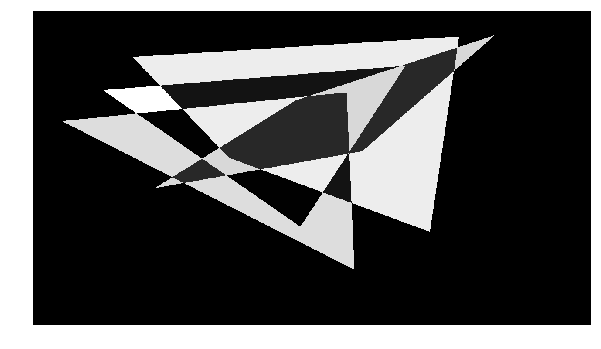

CPU times: user 388 ms, sys: 208 ms, total: 596 ms
Wall time: 374 ms


In [9]:
%%time
im = np.zeros((size[1],size[0]))
lines,im = add_polygon(im,delta_polygon,delta_sides,alpha_poly,min_area,min_line)
print(lines.shape[1],'lines')
imshow(im)

## Add ellipses

In [10]:
def add_ellipses(im,delta_ellipses,radius_ellipses,aplha_ellipses):
    im = im.copy()

    #Parameters
    size = im.shape
    #d_max = np.floor(np.sqrt(size[0]**2+size[1]**2))-10
    n_ellipses = np.random.randint(delta_ellipses[0],delta_ellipses[1])
    
    #add ellipses
    for e in range(n_ellipses):

        #random center
        center_x = np.random.randint(0,size[1])
        center_y = np.random.randint(0,size[0])
        
        #random radius
        radius_x = np.random.random()*(size[1]*radius_ellipses[1]-size[1]*radius_ellipses[0])\
                   +size[1]*radius_ellipses[0]
        radius_y = np.random.random()*(size[0]*radius_ellipses[1]-size[0]*radius_ellipses[0])\
                   +size[0]*radius_ellipses[0]
        radius_x = int(radius_x)
        radius_y = int(radius_y)
        
        #random alpha
        alpha = np.random.random()*(aplha_ellipses[1]-aplha_ellipses[0])+aplha_ellipses[0]
        
        #create ellipse
        rows, cols = ellipse(center_y, center_x, radius_y, radius_x, shape = size)
        
        #new image with the object
        im_tmp = np.zeros(im.shape)
        im_tmp[rows,cols] = 255*alpha
        
        #join images
        im = join_imgs(im, im_tmp)

    return im

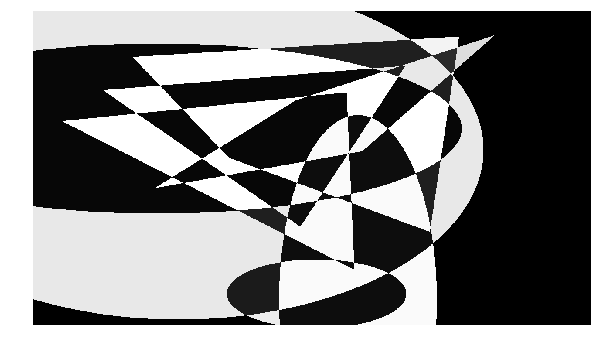

CPU times: user 298 ms, sys: 105 ms, total: 403 ms
Wall time: 264 ms


In [11]:
%%time
im = add_ellipses(im,delta_ellipses,radius_ellipses,aplha_ellipses)
imshow(im)

## Texture
Load all textures:

In [12]:
def load_textures(n_textures):

    ims_texture = list()
    for t in range(n_textures):
        #load
        ims_texture.append(cv2.imread('imgs/texture'+str(t+1)+'.jpg',cv2.IMREAD_GRAYSCALE))
        #resize
        ims_texture[-1] = cv2.resize(ims_texture[-1], size)
        #normalize
        ims_texture[-1] = norm(ims_texture[-1])

    return np.array(ims_texture)

Add texture:

In [13]:
def add_texture(im, ims_texture,alpha_textures):
    im = im.copy()
    
    #random texture
    n_textures = ims_texture.shape[0]
    i_texture = np.random.randint(0,n_textures)
    alpha = np.random.random()*(alpha_textures[1]-alpha_textures[0])+alpha_textures[0]

    #add 
    im = im+ims_texture[i_texture]*alpha

    #print('i:',i_texture,' alpha:',alpha)
    return norm(im)

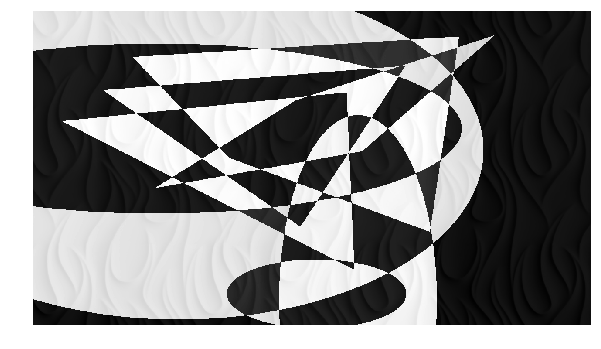

CPU times: user 322 ms, sys: 155 ms, total: 477 ms
Wall time: 279 ms


In [14]:
%%time
ims_texture = load_textures(n_textures)
im = add_texture(im, ims_texture,alpha_textures)
imshow(im)

## Binary Noise

In [15]:
def add_binary_noise(im,noise_probability):
    im = im.copy().astype('int16')
    
    #random image [0,1]
    im_prob = np.random.random(im.shape)

    #invert some pixels 
    #im[im_prob<noise_probability] = 255-im
    im[im_prob<noise_probability] *= -1
    im[im_prob<noise_probability] += 255
         
    return norm(im)

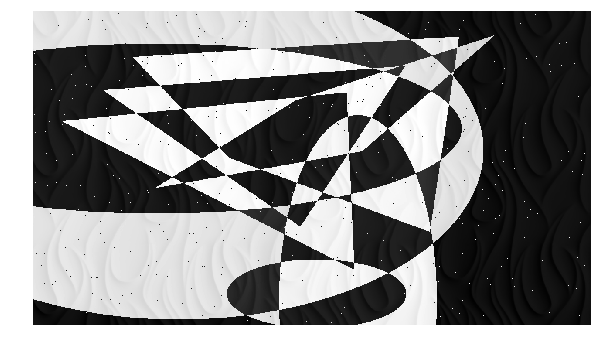

CPU times: user 285 ms, sys: 154 ms, total: 439 ms
Wall time: 250 ms


In [16]:
%%time
im = add_binary_noise(im,binary_noise_probability)
imshow(im)

## Smoothing

In [17]:
def smoothing(im,delta_kernel):
    im = im.copy()
    
    #random kernel, only odd
    kernel = np.random.randint(delta_kernel[0]/2,delta_kernel[1]/2+1)
    kernel = kernel*2+1
    
    #gaussian filter
    im = cv2.GaussianBlur(im,(kernel,kernel),-1)

    return norm(im)

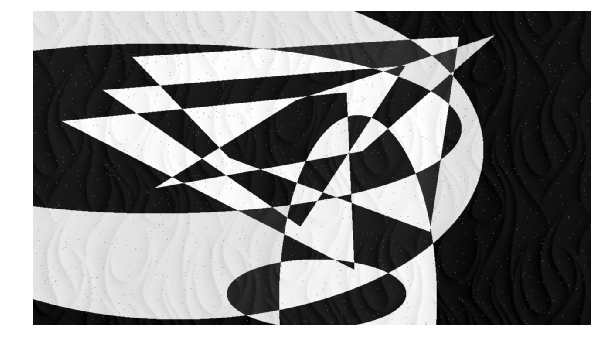

CPU times: user 328 ms, sys: 168 ms, total: 496 ms
Wall time: 270 ms


In [18]:
%%time
im = smoothing(im,smooth_delta_kernel)
imshow(im)

## Noise

In [19]:
def add_noise(im,delta_sigma):
    im = im.copy()
    
    #random noise
    im_noise = np.random.randint(delta_sigma[0],delta_sigma[1],im.shape)
    im_noise = im + im_noise
    
    #limits
    im_noise[im_noise>255] = 255
    im_noise[im_noise<0] = 0
    
    return norm(im_noise)

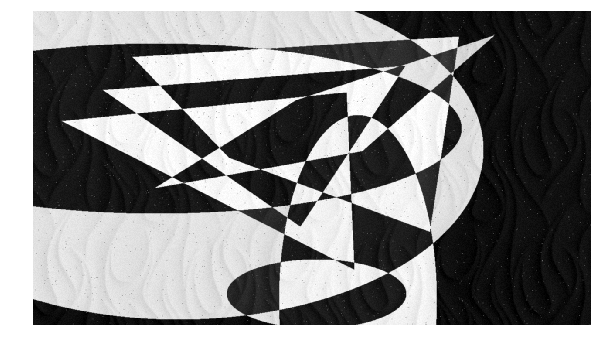

CPU times: user 386 ms, sys: 179 ms, total: 565 ms
Wall time: 340 ms


In [20]:
%%time
im = add_noise(im,noise_delta_sigma)
imshow(im)

## Equalize

In [21]:
from skimage.exposure import equalize_hist
def equalize(im):
    im = im.copy()
    im = equalize_hist(im,mask = (im!=0))
    return norm(im)

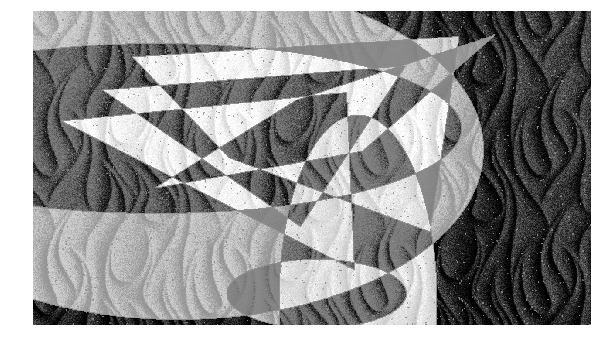

CPU times: user 404 ms, sys: 180 ms, total: 585 ms
Wall time: 359 ms


In [22]:
%%time
im_eq = equalize(im)
imshow(im_eq)

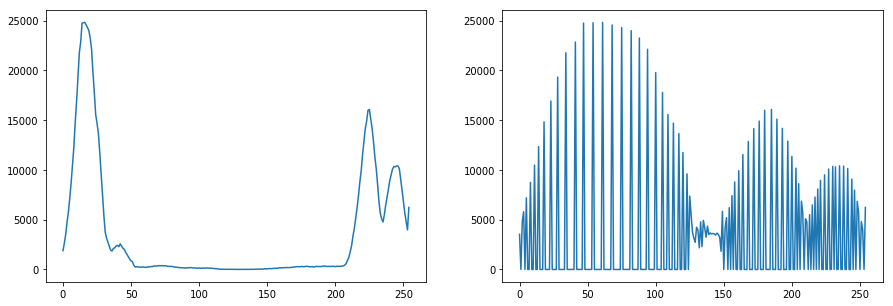

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

hist = cv2.calcHist([im,],[0],None,[256],[0,256])
hist_eq = cv2.calcHist([im_eq],[0],None,[256],[0,256])

ax[0].plot(hist[1:],'-')
ax[1].plot(hist_eq[1:],'-')

## Check

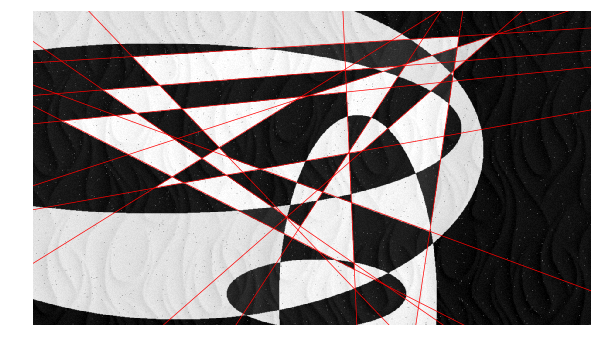

In [26]:
from hough import plot_lines
plot_lines(im,lines[0],lines[1])

## Image generator

In [53]:
def im_generator(n_images=1,
                 size = size,
                 delta_polygon = delta_polygon,
                 delta_sides = delta_sides,
                 alpha_poly = alpha_poly,
                 min_area = min_area,
                 min_line = min_line,
                 delta_ellipses = delta_ellipses,
                 radius_ellipses = radius_ellipses,
                 aplha_ellipses = aplha_ellipses,                 
                 n_textures = n_textures,
                 alpha_textures = alpha_textures,
                 binary_noise_probability = binary_noise_probability,
                 smooth_delta_kernel = smooth_delta_kernel,
                 noise_delta_sigma = noise_delta_sigma):
    
    #load textures
    ims_texture = load_textures(n_textures)
    
    ims = list()
    lines_list = list()
    for i in range(n_images):
        #black image
        im = np.zeros((size[1],size[0]))

        #Add Lines
        lines,im = add_polygon(im,delta_polygon,delta_sides,alpha_poly,min_area,min_line)
        
        #Add Ellipses
        im = add_ellipses(im,delta_ellipses,radius_ellipses,aplha_ellipses)
            
        #Add Texture
        im = add_texture(im, ims_texture,alpha_textures)

        #Add Binary Noise
        im = add_binary_noise(im,binary_noise_probability)

        #Smoothing
        im = smoothing(im,smooth_delta_kernel)

        #Add Noise
        im = add_noise(im,noise_delta_sigma)
        
        #Equalize
        im = equalize(im)
        
        #Save
        ims.append(im)
        lines_list.append(lines)
    
    #to numpy
    ims = np.array(ims)
    
    return lines_list,ims

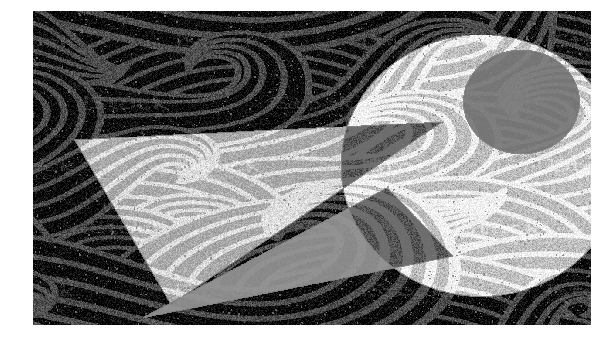

CPU times: user 640 ms, sys: 191 ms, total: 832 ms
Wall time: 601 ms


In [56]:
%%time
lines, ims = im_generator()
imshow(ims[0])

In [57]:
%%time
lines,ims = im_generator(10)

CPU times: user 2.67 s, sys: 216 ms, total: 2.88 s
Wall time: 2.88 s


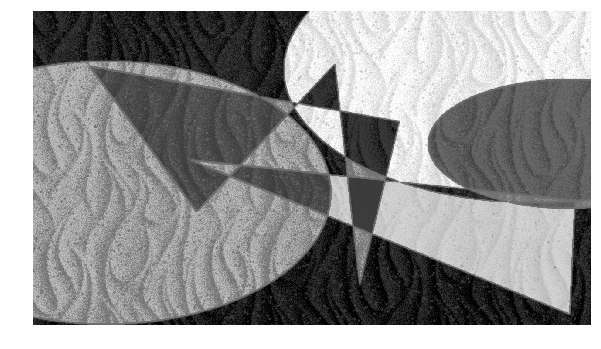

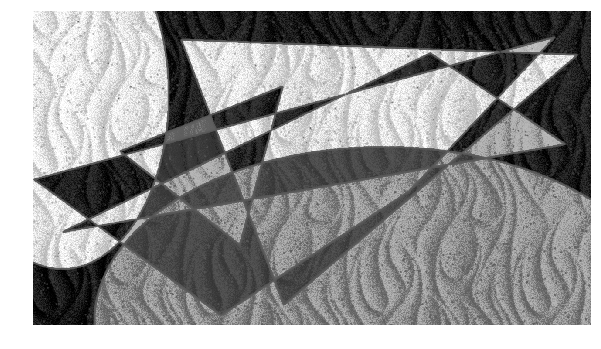

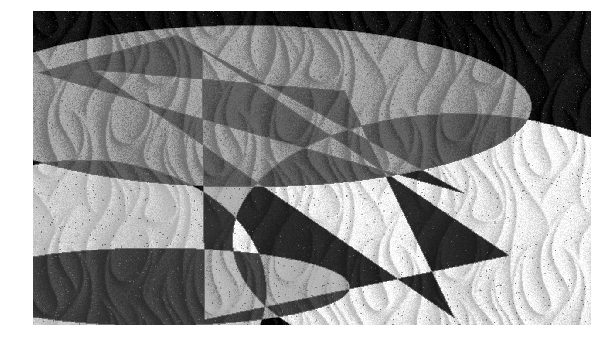

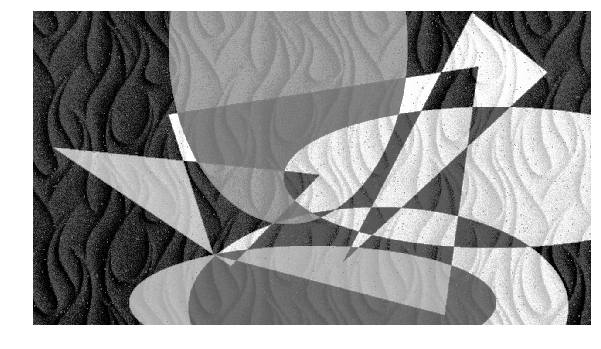

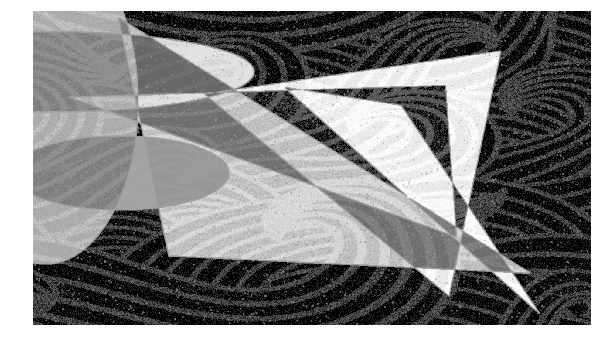

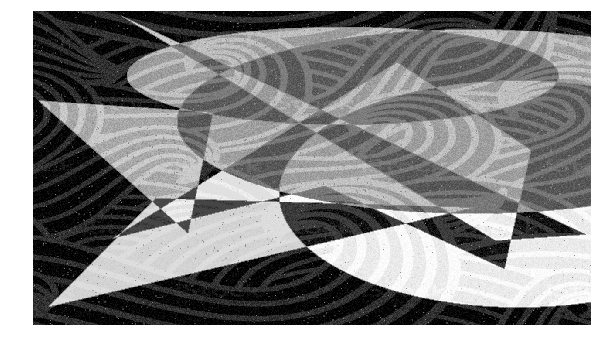

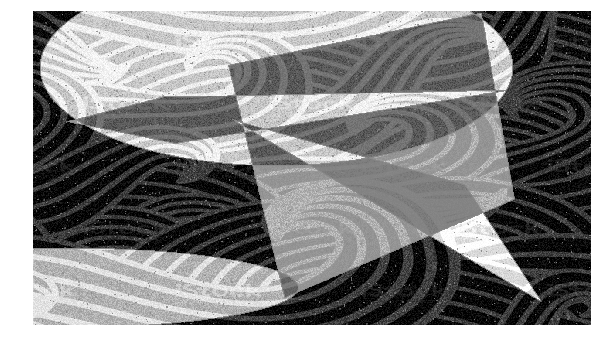

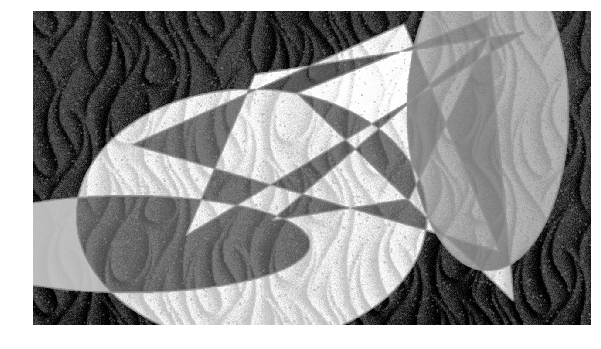

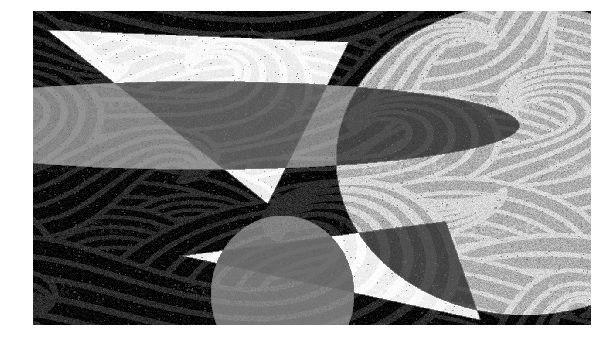

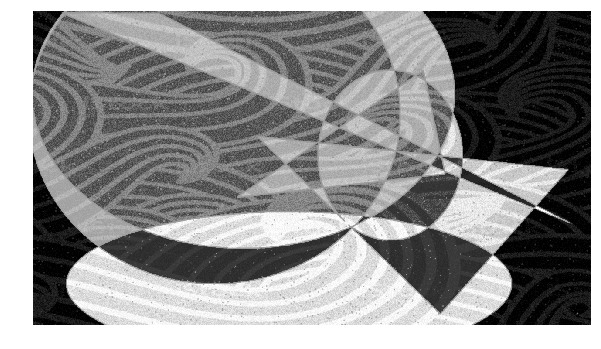

In [58]:
for im in ims:
    imshow(im)